In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cassava-leaf-disease-classification",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 5656 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Cassava Bacterial Blight',
 'Cassava Brown Streak Disease',
 'Cassava Green Mite',
 'Cassava Mosaic Disease',
 'Healthy']

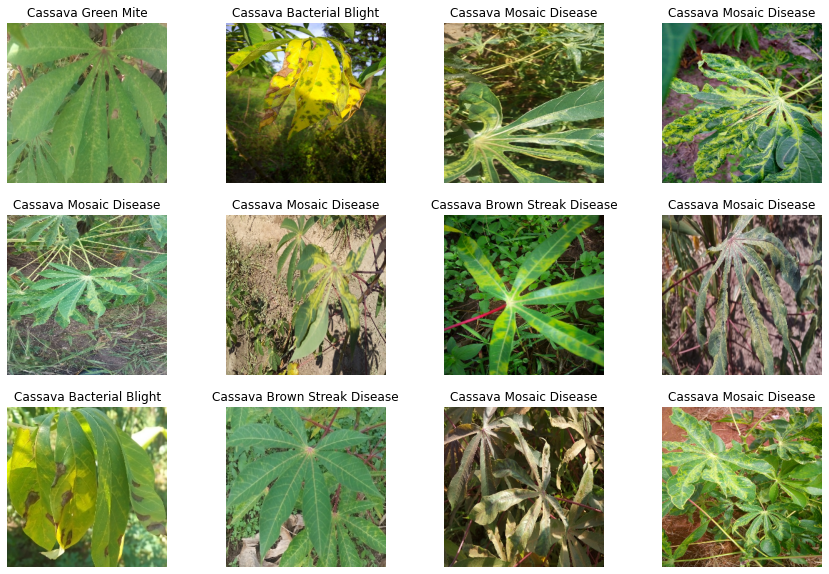

In [6]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
train_size = 0.8
len(dataset)*train_size

141.6

In [8]:
train_ds = dataset.take(141)
len(train_ds)

141

In [9]:
test_ds=dataset.skip(141)
len(test_ds)

36

In [10]:
val_size = 0.1
len(dataset)*val_size

17.7

In [11]:
val_ds = test_ds.take(17)
len(val_ds)

17

In [12]:
test_ds = test_ds.skip(17)
len(test_ds)

19

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.Rescaling(1./255),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
rescaling (Rescaling)        (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[callback],
)

Epoch 1/50
141/141 [==============================] - 689s 5s/step - loss: 1.3501 - accuracy: 0.4761 - val_loss: 1.3056 - val_accuracy: 0.5037
Epoch 2/50
141/141 [==============================] - 678s 5s/step - loss: 1.2001 - accuracy: 0.5667 - val_loss: 1.2029 - val_accuracy: 0.5643
Epoch 3/50
141/141 [==============================] - 672s 5s/step - loss: 1.1308 - accuracy: 0.5949 - val_loss: 1.1229 - val_accuracy: 0.5901
Epoch 4/50
141/141 [==============================] - 672s 5s/step - loss: 1.0849 - accuracy: 0.6088 - val_loss: 1.0293 - val_accuracy: 0.6121
Epoch 5/50
141/141 [==============================] - 678s 5s/step - loss: 1.0389 - accuracy: 0.6206 - val_loss: 1.0779 - val_accuracy: 0.6287
Epoch 6/50
141/141 [==============================] - 669s 5s/step - loss: 1.0151 - accuracy: 0.6301 - val_loss: 0.9611 - val_accuracy: 0.6489
Epoch 7/50
141/141 [==============================] - 667s 5s/step - loss: 0.9853 - accuracy: 0.6405 - val_loss: 0.9729 - val_accuracy: 0.6526

In [21]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 44s 2s/step - loss: 0.6003 - accuracy: 0.9095


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

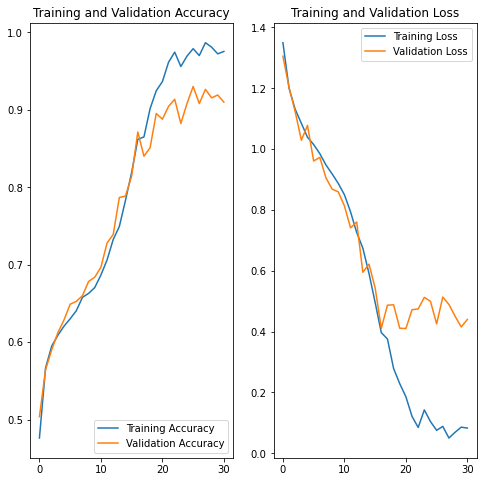

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(31), acc, label='Training Accuracy')
plt.plot(range(31), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(31), loss, label='Training Loss')
plt.plot(range(31), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#HDF5 Format
model.save('cassava_model.h5')

In [26]:
#SavedModel Format
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


In [27]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image

dic = {0 : 'Cassava Bacterial Blight', 1 : 'Cassava Brown Streak Disease', 2 :'Cassava Green Mite', 3 : 'Cassava Mosaic Disease', 4 : 'Healthy'}
model = load_model('cassava_model.h5')

def predict_label(img_path):
    i = image.load_img(img_path, target_size=(256,256))
    i = image.img_to_array(i)
    i = i.reshape(1,256,256,3)
    p = np.argmax(model.predict(i))
    return dic[p]

In [29]:
img_path = "C:/Users/Nicholas/Documents/Cassava-Disease/cassava-leaf-disease-classification/Cassava Brown Streak Disease/train-cbsd-0.jpg"

p = predict_label(img_path)
print(p)

Cassava Brown Streak Disease
